## Final rescale for paper 1

Final figures for the scaling section of paper 1 and cleaner fits for:

* Maximum and minimum squeezing of isopyncals (max $N^2/N^2_0$, min $N^2/N^2_0$ )
* Effective stratification ($N_{eff}$)
* Upwelling flux induced by the canyon ($\Phi$)

* Maximum and minimum squeezing of isopyncals iso-concentration lines (max $\partial_zC/\partial_zC_0$, min $\partial_zC/\partial_zC_0$ ) *These won't be necessary for the paper(?)* 
* Mean concentration just above the rim during the advective phase ($\bar{C}$)
* Tracer upwelling flux induced by the canyon ($\Phi_{Tr}$)

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [32]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [33]:
sns.set_context('paper')
sns.set_style('white')

In [34]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']
RC = CanyonGridOut.variables['RC']

In [35]:
# Constants and scales

g = 9.81 # accel. gravity
Hs = 149.8 # Shelf break depth
s = 0.01 # shelf slope 

def Dh(f,L,N):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U,f,R):
    '''Rossby number'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N,f,W,Hs):
    '''Burger number'''
    return((N*Hs)/(f*W))

def RossbyRad(N,Hs,f):
    '''1st Rossby radius of deformation'''
    return((N*Hs)/f)

def SE(s,N,f,Fw,Rl):
    '''Slope effect '''
    return((s*N)/(f*(Fw/Rl)**0.5))

In [36]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
records = canyon_records.main()

import nocanyon_records 
recordsNoC = nocanyon_records.main()

### Not all runs are used to fit all variables

**records_dyn** has all runs where f, N or U vary. USe this list to fit upwelling flux $\Phi$ and modify *Howatt and Allen 2013*.

**records_epsilon** has all runs in records_dyn plus the runs with a heaviside Kv profile. Use this list to fit $\Phi$ with scaled N.

**records_real** has all runs in records_epsilon plus the runs with a Kv profile inspired in observations.

In [37]:
# Indices of all runs that will be considered for paper 1

select_rec = [0,1,2,3,4,5,51,6,7,8,9,10,17,18,19,20,21,
              22,23,24,25,26,27,29,30,31,32,33,
              34,35,38,39,41,42,43,44,45,46,47,48,49, 52, 53, 54, 55, 56, 57]

for ii in select_rec:
    print(ii,records[ii].label2, records[ii].name)

0 base case CNTDIFF_run38
1 $\uparrow$ $K_{bg}$ CNTDIFF_run37
2 $\uparrow \uparrow$ $K_{bg}$ CNTDIFF_run36
3 $\uparrow$ $N_0$ CNTDIFF_run45
4 $\uparrow \uparrow$ $N_0$ CNTDIFF_run73
5 $\Downarrow$ $N_0$ CNTDIFF_run75
51 $\downarrow \downarrow N_0$ CNTDIFF_run81
6 $\downarrow$ $N_0$ CNTDIFF_run79
7 $\uparrow f$ CNTDIFF_run67
8 $\downarrow \downarrow$ $f$ CNTDIFF_run51
9 $\downarrow f$ CNTDIFF_run69
10 $\Downarrow f$ CNTDIFF_run71
17 $\downarrow$ U LOWER_BF_run01
18 $\downarrow \downarrow$ U LOW_BF_run01
19 $\Downarrow$ U LOWEST_BF_run01
20 $\Downarrow$ U, $\downarrow \downarrow$ $N_0$ LOWEST_BF_run03
21 $\Downarrow$ U, $\uparrow \uparrow$ $N_0$ LOWEST_BF_run05
22 $\Downarrow$ U, $\Downarrow$ $f$ LOWEST_BF_run07
23 $\Downarrow$ U, $\uparrow \uparrow K_{can}$ LOWEST_BF_run11
24 $K_{can}$ Monterey (bot) 3DVISC_REALISTIC_run01
25 $K_{can}$ Eel (bot) 3DVISC_REALISTIC_run02
26 $K_{can}$ Monterey 3DVISC_REALISTIC_run03
27 $K_{can}$ Ascension (bot) 3DVISC_REALISTIC_run05
29 $\Uparrow \Uparrow K

In [38]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22, 52, 53, 54, 55, 56, 57]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,39,41,42,43,44,45,46,47,48,49]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,38,41,42,39,43,44,45,46,47,48,49,24,25,26,27, 52,53, 54, 55, 56, 57]
records_real = []
for ii in ind:
    records_real.append(records[ii])

In [39]:
records_sel = []

for ind in select_rec:
    records_sel.append(records[ind])
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' 
            %(records[ind].exp_code,records[ind].exp_code,records[ind].run_num))
    dfcan = pd.read_csv(file)
    records[ind].HCW = dfcan['HCW']
    records[ind].HCWTr1 = dfcan['HCWTr1']
    records[ind].TrMass = dfcan['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    records[ind].TrMassTot = dfcan['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']

In [40]:
t=6.5
stname = 'UwH' #Station downstream head of canyon

keys2 = ['N_tt12','N_tt14']

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = np.empty(len(keys2))
    Nbe = np.empty(len(keys2))
    
    if records[ind].L > 13000:
        print(records[ind].L)
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.max(df[keys2[ii]][:]) 
            Nbe[ii] = np.min(df[keys2[ii]][12:16]) 
    
    elif (records[ind].L < 13000) & (records[ind].L > 8500):
        print(records[ind].L)
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.max(df[keys2[ii]][:]) 
            Nbe[ii] = np.min(df[keys2[ii]][16:19]) 
    
        
    else:
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.max(df[keys2[ii]][:]) 
            Nbe[ii] = np.min(df[keys2[ii]][20:23]) 
        
        
    records[ind].Nab = np.mean(Nab)
    records[ind].Nbe = np.mean(Nbe)
    records[ind].Nab_std = np.std(Nab)
    records[ind].Nbe_std = np.std(Nbe)

16592.7
16592.7
12407.7
12407.7
16592.7
16592.7


In [41]:
keys2 = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16','dTrdz_tt18']

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    dTrab = 0
    dTrbe = 0
    
    if records[ind].L > 13000:
        for key,ii in zip(keys2, range(len(keys2))):
            dTrab = dTrab + np.min(df[keys2[ii]][:]) 
            dTrbe = dTrbe + np.max(df[keys2[ii]][12:16]) 
        records[ind].dTr0 = df['dTrdz_tt00'][10] 
    
    elif (records[ind].L < 13000) & (records[ind].L > 8500):
        for key,ii in zip(keys2, range(len(keys2))):
            dTrab = dTrab + np.min(df[keys2[ii]][:]) 
            dTrbe = dTrbe + np.max(df[keys2[ii]][16:19]) 
        records[ind].dTr0 = df['dTrdz_tt00'][10] 
   
    else:
        for key,ii in zip(keys2, range(len(keys2))):
            dTrab = dTrab + np.min(df[keys2[ii]][:]) #0:20
            dTrbe = dTrbe + np.max(df[keys2[ii]][20:23]) #20:24
        records[ind].dTr0 = df['dTrdz_tt00'][10]
    records[ind].dTr_ab = dTrab/  len(keys2)
    records[ind].dTr_be = dTrbe/  len(keys2)
    

In [42]:
keys2 = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16','Tr_profile_tt18']

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = np.zeros(len(keys2))
    
    if records[ind].L > 13000:
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.nanmean(df[keys2[ii]][11:13]) # just above rim depth
        records[ind].Tr0 = (df['Tr_profile_tt00'][13])
    elif (records[ind].L < 13000) & (records[ind].L > 8500):
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.nanmean(df[keys2[ii]][15:17]) # just above rim depth
        records[ind].Tr0 = (df['Tr_profile_tt00'][17])
    else:
        for key,ii in zip(keys2, range(len(keys2))):
            Nab[ii] = np.nanmean(df[keys2[ii]][19:21]) # just above rim depth
        records[ind].Tr0 = (df['Tr_profile_tt00'][21])
    
    records[ind].Tr = np.nanmean(Nab)
    records[ind].Tr_std = np.std(Nab)
    

## Stratification and upwelling flux

In previous notebooks I found that the upwelling flux is porportional to an effective stratification $N_{eff}$ given by the weighted sum of the maximum stratification above the rim, near the head and the minimum stratification below the rim:

$$N_{eff} = {0.75N_{max}+0.25N_{min}}$$

So first, we scale $N_{max}$ and $N_{min}$ using the information we got from the 1D model and modifications to the 1D model due to the enhanced diffusion above the rim when $\epsilon$ is larger than the step case.

Once we get both N's, we can scale $N_{eff}$ and use it in the depth scale $D_h$ in the scaling for $\Phi$ by Howatt and Allen as $D_{eff}=fL/N_{eff}$, with proper fitting parameters.

In [43]:
# Get kv form initial files

records_kv_files = [24,25,26,27,29,30,31,32,33,34,38,39,41,42,43,44,45,46,47,48,49]

kv_dir = '/ocean/kramosmu/Building_canyon/BuildCanyon/Stratification/616x360x90/'
ini_kv_files = [kv_dir + 'KrDiff_Mty_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Eel_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Mty_rim_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_Asc_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e10_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e50_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e15_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e75_kv1E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv1E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e25_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e100_kv5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv8E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_exact1p2E2_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv2p5E3_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_kv5E4_90zlev_616x360_Quad.bin',
                kv_dir + 'KrDiff_e05_exact_nosmooth_90zlev_616x360_Quad.bin',
                ]

dt = np.dtype('>f8')  # float 64 big endian
st = [240, 200] # y, x indices of UwH station
Hrim = 135
dd = 1
ini_kv_profiles = np.zeros((len(ini_kv_files),nz))

for file, ii in zip(ini_kv_files, records_kv_files):
    data = np.fromfile(file, dt)
    ini_kv = np.reshape(data,(90,360,616),order='C')
    KK = ini_kv[:, st[0], st[1]] 
    
    records[ii].Zdif = (((KK[int(Hrim/5)+1]-KK[int(Hrim/5)-1]))*t*3600*24)**0.5
    records[ii].dk =  KK[int(Hrim/5)+1]-KK[int(Hrim/5)-1]
    records[ii].Kz =  KK[int(Hrim/5)-4]
    records[ii].Kz_be =  KK[int(Hrim/5)+4]

In [44]:
for rec in records_real:

    Dz = abs(RC[int(Hrim/5)+1]-RC[int(Hrim/5)-1])
    rec.Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,rec.R))*rec.L)**(0.5))/rec.N
    
    if rec.kv == rec.kbg:
        rec.Zdif = 0
        rec.Sdif_min = np.exp(-0.15*rec.Zdif/Dz) # -0.1 comes from the 1D model
        rec.dk = 0
        rec.Kz = 1E-5
        rec.Kz_be = 1E-5
        rec.Sdif_max = (rec.Zdif/Dz)*np.exp(-(rec.Kz*t*3600*24)/((rec.epsilon)**2))
    
    else:
        rec.Sdif_min = np.exp(-0.15*rec.Zdif/Dz)
        rec.Sdif_max = (rec.Zdif/Dz)*np.exp(-(rec.Kz*t*3600*24)/((rec.epsilon)**2))
        
    rec.S_max = (rec.Z/Hs)*np.exp(-rec.Kz*t*3600*24/rec.Z**2)
    rec.S_min = (rec.Z/Hs)*np.exp(-rec.Kz_be*t*3600*24/rec.Z**2)

In [45]:
X1_be = np.array([rec.S_min for rec in records_epsilon])
X2_be = np.array([rec.Sdif_min for rec in records_epsilon])
Y_be = np.array([(rec.Nbe)**2/(rec.N**2) for rec in records_epsilon])

X1_ab = np.array([rec.S_max for rec in records_epsilon])
X2_ab = np.array([rec.Sdif_max for rec in records_epsilon])
Y_ab = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])

In [46]:
from sklearn import linear_model
reg_be = linear_model.LinearRegression()
reg_be.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(r'min $N^2/N^2_0$ = %1.2f $S^-$ + %1.2f $S^-_{diff}$  %1.2f ' %
      (reg_be.coef_[0],reg_be.coef_[1],reg_be.intercept_))

reg_ab = linear_model.LinearRegression()
reg_ab.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(r'max $N^2/N^2_0$ = %1.2f $S^+$ + %1.2f $S^+_{diff}$ + %1.2f ' %
      (reg_ab.coef_[0],reg_ab.coef_[1],reg_ab.intercept_))

min $N^2/N^2_0$ = 4.26 $S^-$ + 2.11 $S^-_{diff}$  -1.02 
max $N^2/N^2_0$ = 11.50 $S^+$ + 0.22 $S^+_{diff}$ + 0.91 


In [47]:
# Save values of N_eff and Phi

for rec in records_sel:  
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) 
                            for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) 
                               for ii in range (8,18)]))
    rec.Phi = Phi
    rec.Phi_std = Phi_std

for rec in records_real:
    rec.Nbe_scaled =  np.sqrt(reg_be.coef_[0]*rec.S_min +
                              reg_be.coef_[1]*rec.Sdif_min +
                              reg_be.intercept_)*rec.N
    rec.Nab_scaled =  np.sqrt(reg_ab.coef_[0]*rec.S_max +
                              reg_ab.coef_[1]*rec.Sdif_max +
                              reg_ab.intercept_)*rec.N
     
    if  (reg_be.coef_[0]*rec.S_min+ reg_be.coef_[1]*rec.Sdif_min +
         reg_be.intercept_)< 0 :
        rec.N_eff_scaled = (0.75*rec.Nab_scaled)
    else:
        rec.N_eff_scaled =  (0.75*rec.Nab_scaled + 0.25*rec.Nbe_scaled) 
    
    rec.Neff = (0.75*rec.Nab+0.25*rec.Nbe)

In [48]:
# find best slope parameter to use

for param in np.linspace(0.3, 0.6, 80):
    for rec in records_real:
        Se = SE(s, rec.N, rec.f, F(Ro(rec.u_mod,rec.f,rec.Wiso)), Ro(rec.u_mod,rec.f,rec.L))
        rec.X = ((F(Ro(rec.u_mod,rec.f,rec.Wiso)))**(1.5))*((Ro(rec.u_mod,rec.f,rec.L))**(0.5))*((1-param*Se)**3)

        rec.Phi_nonDim = rec.Phi/(rec.u_mod*rec.W*Dh(rec.f,rec.L,rec.N_eff_scaled))
        
    Y_array = np.array([rec.Phi_nonDim for rec in records_epsilon])
    X_array = np.array([rec.X for rec in records_epsilon])

    slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(X_array,Y_array)

    print('Using parameter %1.2f: slope = %1.2f, intercept = %1.3f, r-value = %1.3f' %(param, slope2, intercept2, r_value2))

Using parameter 0.30: slope = 1.95, intercept = -0.008, r-value = 0.805
Using parameter 0.30: slope = 1.99, intercept = -0.009, r-value = 0.810
Using parameter 0.31: slope = 2.03, intercept = -0.009, r-value = 0.816
Using parameter 0.31: slope = 2.07, intercept = -0.010, r-value = 0.821
Using parameter 0.32: slope = 2.11, intercept = -0.010, r-value = 0.826
Using parameter 0.32: slope = 2.15, intercept = -0.011, r-value = 0.831
Using parameter 0.32: slope = 2.20, intercept = -0.012, r-value = 0.837
Using parameter 0.33: slope = 2.24, intercept = -0.012, r-value = 0.842
Using parameter 0.33: slope = 2.28, intercept = -0.013, r-value = 0.847
Using parameter 0.33: slope = 2.32, intercept = -0.013, r-value = 0.851
Using parameter 0.34: slope = 2.36, intercept = -0.014, r-value = 0.856
Using parameter 0.34: slope = 2.41, intercept = -0.014, r-value = 0.861
Using parameter 0.35: slope = 2.45, intercept = -0.015, r-value = 0.866
Using parameter 0.35: slope = 2.50, intercept = -0.015, r-value 

In [49]:
# My re-fit of Howatt and Allen's function for Phi gave:
slope = 2.10
param = 0.40
intercept = -0.004

#Using parameter 0.52: slope = 4.47, intercept = -0.015, r-value = 0.973

slope2 = 4.47
param2 = 0.52
intercept2 = -0.015

for rec in records_real:
    
    Se = SE(s, rec.N, rec.f, F(Ro(rec.u_mod,rec.f,rec.Wiso)), Ro(rec.u_mod,rec.f,rec.L))
    
    HA2013=((slope*(F(Ro(rec.u_mod,rec.f,rec.Wiso))**(3/2))*(Ro(rec.u_mod,rec.f,rec.L)**(1/2))*((1-param*Se)**3))+intercept)
    RA2018 = (slope2*(F(Ro(rec.u_mod,rec.f,rec.Wiso))**(3/2))*(Ro(rec.u_mod,rec.f,rec.L)**(1/2))*((1-param2*Se)**3))+intercept2

    rec.HA2013 = HA2013
    rec.HA2013_sqe = (rec.Phi-rec.HA2013)**2
    
    rec.RA2018 = RA2018
    rec.RA2018_sqe = (rec.Phi-rec.RA2018)**2

### Tracer gradient

In [50]:
X1_be = np.array([rec.S_min for rec in records_epsilon])
X2_be = np.array([rec.Sdif_min for rec in records_epsilon])
Y_be = np.array([(rec.dTr_be)/(rec.dTr0) for rec in records_epsilon])

X1_ab = np.array([rec.S_max for rec in records_epsilon])
X2_ab = np.array([rec.Sdif_max for rec in records_epsilon])
Y_ab = np.array([(rec.dTr_ab)/(rec.dTr0) for rec in records_epsilon])

In [51]:
from sklearn import linear_model
reg_be_dTr = linear_model.LinearRegression()
reg_be_dTr.fit (np.transpose([X1_be,X2_be]),np.transpose(Y_be) )
print(r'min $dzC/dzCo$ = %1.2f $S^-$ + %1.2f $S^-_{diff}$  %1.2f ' %
      (reg_be_dTr.coef_[0],reg_be_dTr.coef_[1],reg_be_dTr.intercept_))

reg_ab_dTr = linear_model.LinearRegression()
reg_ab_dTr.fit (np.transpose([X1_ab, X2_ab]),np.transpose(Y_ab) )
print(r'max $dzC/dzCo$ = %1.2f $S^+$ + %1.2f $S^+_{diff}$  %1.2f ' %
      (reg_ab_dTr.coef_[0],reg_ab_dTr.coef_[1],reg_ab_dTr.intercept_))


min $dzC/dzCo$ = 5.50 $S^-$ + 1.47 $S^-_{diff}$  -0.85 
max $dzC/dzCo$ = 11.41 $S^+$ + 0.23 $S^+_{diff}$  0.91 


In [52]:
# save values of dTr scaled and PhiTr
for rec in records_sel:
    can_eff = rec.TrMass
    Phi_Tr = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    Phi_Tr_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (12,18)]))
    
    rec.PhiTr = Phi_Tr
    rec.PhiTr_std = Phi_Tr_std

for rec in records_real:
    rec.dTr_ab_scaled = (reg_ab_dTr.coef_[0]*rec.S_max+
                         reg_ab_dTr.coef_[1]*rec.Sdif_max+
                         reg_ab_dTr.intercept_)*rec.dTr0
    rec.dTr_be_scaled = (reg_be_dTr.coef_[0]*rec.S_min+
                         reg_be_dTr.coef_[1]*rec.Sdif_min+
                         reg_be_dTr.intercept_)*rec.dTr0

### Concentration

In [53]:
# Fit mean concentration just above the rim - I know using the max 
# worked slightly better (smaller mse). Co is the initial concentration just above rim depth

X1_tr = np.array([rec.S_max for rec in records_epsilon])
X2_tr = np.array([rec.Sdif_max for rec in records_epsilon])
Y_tr = np.array([(rec.Tr/rec.Tr0) for rec in records_epsilon])

reg_Tr = linear_model.LinearRegression()
reg_Tr.fit (np.transpose([X1_tr,X2_tr]),np.transpose(Y_tr) )
print(r'$\bar{C}/Co$ = %1.2f $S^+$ + %1.2f $S^+_{diff}$  %1.2f ' %
      (reg_Tr.coef_[0],reg_Tr.coef_[1],reg_Tr.intercept_))

for rec in records_real:
    rec.Tr_scaled = (reg_Tr.coef_[0]*(rec.S_max)+ reg_Tr.coef_[1]*(rec.Sdif_max)+
                         reg_Tr.intercept_)*rec.Tr0
print(rec.Tr0)
print(rec.dTr0)

$\bar{C}/Co$ = 0.50 $S^+$ + 0.06 $S^+_{diff}$  1.01 
4.33891201019
-0.0359832525253


### Tracer flux

In [54]:
Y_array = np.array([rec.PhiTr for rec in records_epsilon])
X_array = np.array([rec.RA2018*(rec.u_mod*rec.W*Dh(rec.f,rec.L,rec.N_eff_scaled))*
                    (rec.Tr_scaled) for rec in records_epsilon])
slope6, intercept6, r_value6, p_value6, std_err6 = scipy.stats.linregress(np.squeeze(X_array),
                                                                          np.squeeze(Y_array))
    
for rec in records_real:
    
    depth_scale = Dh(rec.f,rec.L,rec.N_eff_scaled)
        
    rec.Phi_scaled = rec.RA2018*(rec.u_mod*rec.W*depth_scale)
    rec.PhiTr_scaled = np.squeeze((slope6*rec.Phi_scaled*(rec.Tr_scaled))+intercept6)
    
print('\Phi/UWD_{eff} = %1.2f Fw^{3/2} Ro^{1/2} (1-%1.2f *Se)^3 +%1.2f' %(slope2,param2,intercept2))    
print('\Phi_{Tr} = %1.2f $\Phi \ bar{C}$ + %1.2f ' %(slope6, intercept6))    

\Phi/UWD_{eff} = 4.47 Fw^{3/2} Ro^{1/2} (1-0.52 *Se)^3 +-0.01
\Phi_{Tr} = 1.01 $\Phi \ bar{C}$ + -3790.24 


## Figures

12.0727297327 12.2735562229
13.265485643 13.7081170114
14.8569135599 14.535337394
10.6640344225 11.2975735291
10.8213674691 11.4659384993
11.290193455 11.7462446765
12.0614023621 12.2512870033
12.111191534 11.2272534394
12.1044587619 11.5520469043
12.0957384786 11.6395733385
11.4913171647 11.6144295219
10.8046765497 11.3023872137
8.98280002107 9.99866512122
7.84799998434 8.90133110289
11.2382603271 11.8801189214
9.11986067777 9.22092073646
11.0591289378 11.4783023754
11.108272175 10.95691608
10.1884386895 9.36996848319
9.55839069461 8.69400099698
11.2024277134 11.5742704191
9.75766756096 8.84117126635
11.9367798423 11.7875124277
11.954287935 11.3419177721
11.7711345473 11.1179101284
11.5307963097 11.481372903
11.5358066751 11.0455681872
10.6865391375 9.50643175965
11.2289092762 11.1643546921
10.8254089041 11.3183512038
11.7655690855 11.6040735353
11.9904130311 11.7090714827
10.8354205657 11.2933066537
nan 8.2307274163
11.8365189965 10.4766011508
11.6222092269 10.3973529967
10.715645216

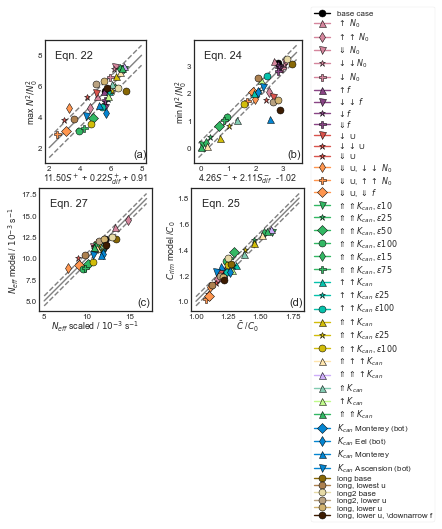

In [55]:
sns.set_context('paper')
plt.rcParams['font.size'] = 11.0
f = plt.figure(figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(2, 2,wspace=0.2)
ax1 = plt.subplot(gs[0,0])
ax0 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[1,1])


# ---- plot 1:1 line ----
ax0.plot(np.linspace(-0.1,3.5,20),np.linspace(-0.1,3.5,20), '-',color='0.5')
ax1.plot(np.linspace(2,8,20),np.linspace(2,8,20), '-', color='0.5')
ax3.plot(np.linspace(5, 17, 20),np.linspace(5,17, 20),'-', color='0.5')
ax2.plot(np.linspace(1, 1.8, 20),np.linspace(1, 1.8, 20),'-', color='0.5')

# ---- plot error -----
# MSE ax0    
phi_array = np.array([(rec.Nbe_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nbe)**2/(rec.N**2)  for rec in records_epsilon])
x_fit = np.linspace(-0.1, 3.5, 50)
mean_sq_err = np.nanmean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([(rec.Nab_scaled/rec.N)**2 for rec in records_epsilon])
sca_array = np.array([(rec.Nab)**2/(rec.N**2) for rec in records_epsilon])
x_fit = np.linspace(2,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax2    
phi_array = np.array([rec.N_eff_scaled/1E-3 for rec in records_epsilon])
sca_array = np.array([rec.Neff/1E-3 for rec in records_epsilon])
x_fit = np.linspace(5,17, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax3    
phi_array = np.squeeze(np.array([rec.Tr_scaled/rec.Tr0 for rec in records_epsilon]))
sca_array = np.squeeze(np.array([rec.Tr/rec.Tr0 for rec in records_epsilon]))
x_fit = np.linspace(1,1.8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt0 = ax0.plot((rec.Nbe_scaled/rec.N)**2,(rec.Nbe)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    
    plt1 = ax1.plot((rec.Nab_scaled/rec.N)**2,(rec.Nab)**2/(rec.N**2),
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2) 
    
    plt2 = ax3.plot(rec.N_eff_scaled/1E-3,rec.Neff/1E-3,
                    marker = rec.mstyle,
                    markersize = 7,
                    color = sns.xkcd_rgb[rec.color2],
                    markeredgewidth=0.5,
                    markeredgecolor = 'k',
                    label=rec.label2)
    print(rec.N_eff_scaled/1E-3,rec.Neff/1E-3)
    plt3 = ax2.plot(rec.Tr_scaled/rec.Tr0,
                    (rec.Tr/rec.Tr0),
                     marker = rec.mstyle,
                     markersize = 7,
                     color = sns.xkcd_rgb[rec.color2],
                     markeredgewidth=0.5,
                     markeredgecolor = 'k',
                     label=rec.label2)

    
    
# ---- aesthetics -----
#ax0.set_xlim(-0.1,3.5)
#ax0.set_ylim(-0.1,3.5)

#ax1.set_xlim(2,8)
#ax1.set_ylim(2,8)

#ax3.set_xlim(7,15.5)
#ax3.set_ylim(7,15.5)

#ax2.set_xlim(1,1.62)
#ax2.set_ylim(1,1.62)


ax0.set_ylabel('min $N^2/N^2_0$',labelpad=-1.5)
ax1.set_ylabel('max $N^2/N^2_0$',labelpad=-1.5)
ax0.set_xlabel(r'%1.2f$S^-$ + %1.2f$S^-_{dif}$  %1.2f' %(reg_be.coef_[0], 
                                                         reg_be.coef_[1], 
                                                         reg_be.intercept_),labelpad=0.5)
ax1.set_xlabel(r'%1.2f$S^+$ + %1.2f$S^+_{dif}$ + %1.2f' %(reg_ab.coef_[0], 
                                                          reg_ab.coef_[1], 
                                                          reg_ab.intercept_),labelpad=0.5)

ax3.set_ylabel('$N_{eff}$ model / $10^{-3}$ s$^{-1}$', labelpad=0)
ax3.set_xlabel('$N_{eff}$ scaled / $10^{-3}$ s$^{-1}$',labelpad=0.0)
ax2.set_ylabel(r'$C_{rim}$ model /$C_0$', labelpad=0)
ax2.set_xlabel(r'$\bar{C}$ /$C_0$', labelpad=0.0)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)
ax3.tick_params(axis='x', pad=2)
ax2.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)
ax3.tick_params(axis='y', pad=2)
ax2.tick_params(axis='y', pad=2)

ax0.legend(bbox_to_anchor=(1.05,1.3), ncol=1,columnspacing=0.1,labelspacing=0.1,frameon=True )

ax0.set_aspect(1)
ax1.set_aspect(1)
ax2.set_aspect(1)
ax3.set_aspect(1)

ax1.text(0.1,0.85,'Eqn. 22',transform=ax1.transAxes)
ax0.text(0.1,0.85,'Eqn. 24',transform=ax0.transAxes)
ax3.text(0.1,0.85,'Eqn. 27',transform=ax3.transAxes)
ax2.text(0.1,0.85,'Eqn. 25',transform=ax2.transAxes)

ax1.text(0.87,0.05,'(a)',transform=ax1.transAxes)
ax0.text(0.87,0.05,'(b)',transform=ax0.transAxes)
ax3.text(0.87,0.05,'(c)',transform=ax3.transAxes)
ax2.text(0.87,0.05,'(d)',transform=ax2.transAxes)

plt.savefig('figure10_v2.eps',format='eps',bbox_inches='tight')


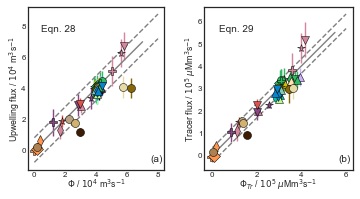

In [56]:
sns.set_context('paper')
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (6,3)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])

# ---- plot 1:1 lines ----
ax0.plot(np.linspace(0,7,50),np.linspace(0,7,50),'-', color='0.5')
ax1.plot(np.linspace(0,5.5,50),np.linspace(0,5.5,50),'-', color='0.5')

# ---- plot errors ----
# MSE ax0    
phi_array = np.array([rec.Phi/1E4 for rec in records_dyn])
sca_array = np.array([rec.Phi_scaled/1E4  for rec in records_dyn])
x_fit = np.linspace(0,8, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# MSE ax1    
phi_array = np.array([rec.PhiTr_scaled/1E5 for rec in records_epsilon])
sca_array = np.array([rec.PhiTr/1E5 for rec in records_epsilon])
x_fit = np.linspace(0,6, 50)
mean_sq_err = np.mean(((phi_array)-(sca_array))**2)
upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')

# ---- plot scaling ----
for rec in records_real:
    
    plt1 = ax0.errorbar(rec.Phi_scaled/1E4,
                        rec.Phi/1E4,
                        yerr=rec.Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 8,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)
    
    plt1 = ax1.errorbar(rec.PhiTr_scaled/1E5,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 8,
                        color = sns.xkcd_rgb[rec.color2],
                        markeredgewidth=0.5,
                        markeredgecolor = 'k',
                        label=rec.label2)


# ---- aesthetics ----
ax0.set_ylabel('Phi',labelpad=0.5)
ax0.set_ylabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax1.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax0.set_xlabel(r'$\Phi$ / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5 )
ax1.set_xlabel(r'$\Phi_{Tr}$ / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

#ax0.set_xlim(-0.2,7.2)
#ax0.set_ylim(-0.2,7.2)

#ax1.set_xlim(-0.2,5.8)
#ax1.set_ylim(-0.2,5.8)

ax0.text(0.1,0.85,'Eqn. 28',transform=ax0.transAxes)
ax1.text(0.1,0.85,'Eqn. 29',transform=ax1.transAxes)

ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.9,0.05,'(b)',transform=ax1.transAxes)

ax0.tick_params(axis='x', pad=2)
ax1.tick_params(axis='x', pad=2)

ax0.tick_params(axis='y', pad=2)
ax1.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1)
#ax0.plot(57261.9871812/1E4,40630.372436/1E4, 'o', color='brown')
#ax1.plot(520483.538981/1E5,298566.920079/1E5, 'o', color='brown')
plt.savefig('figure11_v2.eps',format='eps',bbox_inches='tight')


base
higher $N$
highest $N$
lower $N$
higher $N$
medium $N$
higher $f$
lower $f$
low $f$
lowest $f$
lower $U$
low $U$
lowest $U$
lowest $U$, lowest $N$
lowest $U$, highest $N$
lowest $U$, lowest $f$
$\K_{can}=10^{-2}$, $\epsilon=10$
$\K_{can}$, $\epsilon=25$
$\K_{can}$, $\epsilon=50$
$\K_{can}$, $\epsilon=100$
$\K_{can}$, $\epsilon=15$
$\K_{can}$, $\epsilon=75$
$\K_{can}=5\times10^{-3}$, $\epsilon=5$
$\K_{can}=1\times10^{-3}$, $\epsilon=25$
$\K_{can}=1\times10^{-3}$, $\epsilon=100$
$\K_{can}=10^{-3}$, $\epsilon=5$
$\K_{can}=5\times10^{-3}$, $\epsilon=25$
$\K_{can}=5\times10^{-3}$, $\epsilon=100$
$K_{can}=8\times10^{-3}$, $\epsilon=5$
$K_{can}=1.2\times10^{-2}$, $\epsilon=5$
$K_{can}=2.5\times10^{-3}$, $\epsilon=5$
$K_{can}=5\times10^{-4}$, $\epsilon=5$
$K_{can}=10^{-2}$, $\epsilon=5$
$\K_{can}$ Mty, bottom
$\K_{can}$ Eel, bottom
$\K_{can}$ Mty, rim
$\K_{can}$ Asc, bottom


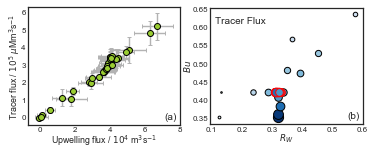

In [57]:
sns.set_context('paper')
sns.set_style("white")
plt.rcParams['font.size'] = 10.0
f = plt.figure(figsize = (6,3)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# ---- plot scaling ----
for rec in records_real[:-6]:
    print(rec.label)
    plt1 = ax0.errorbar(rec.Phi/1E4,
                        rec.PhiTr/1E5,
                        yerr=rec.PhiTr_std/1E5,
                        xerr = rec.Phi_std/1E4,
                        marker = '.',
                        markersize = 12,
                        color = 'yellowgreen',
                        markeredgewidth=1,
                        markeredgecolor = 'k',
                        label=rec.label2,
                        capsize=2,
                        ecolor = '0.7')
    if rec.kv <= 1E-5:
        plt1 = ax1.scatter(Ro(U=rec.u_mod, f=rec.f, R=rec.Wiso),
                           Bu(rec.N, rec.f,rec.W,Hs),
                           c = rec.PhiTr/1E5,
                           vmin=0, vmax=5,
                           cmap='Blues',
                           marker = 'o',
                           s = (rec.PhiTr/1E5)*20,
                           linewidths=1,
                           edgecolors='k',
                           )
    else:
        plt1 = ax1.scatter(Ro(U=rec.u_mod, f=rec.f, R=rec.Wiso),
                           Bu(rec.N, rec.f,rec.W,Hs),
                           c = rec.PhiTr/1E5,
                           vmin=0, vmax=5,
                           cmap='Blues',
                           marker = 'o',
                           s = (rec.PhiTr/1E5)*20,
                           linewidths=1,
                           edgecolors='r',
                           )
# Longer canyon runs  


# ---- aesthetics ----
ax0.set_xlabel('Upwelling flux / $10^4$ m$^3$s$^{-1}$', labelpad=-0.5)
ax0.set_ylabel('Tracer flux / $10^5$ $\mu$Mm$^3$s$^{-1}$', labelpad=-0.5)

ax1.set_xlabel('$R_W$', labelpad=-0.5)
ax1.set_ylabel('$Bu$', labelpad=-0.5)

#ax0.set_xlim(-0.2,7.2)
#ax0.set_ylim(-0.2,7.2)

ax0.tick_params(axis='x', pad=2)
ax0.tick_params(axis='y', pad=2)

ax1.tick_params(axis='x', pad=2)
ax1.tick_params(axis='y', pad=2)

ax0.set_aspect(1)
ax1.set_aspect(1.2)

ax1.text(0.11,0.61,'Tracer Flux')
ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes)
ax1.text(0.9,0.05,'(b)',transform=ax1.transAxes)
plt.savefig('figure_fluxes_comparison.eps',format='eps',bbox_inches='tight')


### Tables

In [58]:
print ("\t".join(['Experiment &','$\kappa_{bg}$ &','$\kappa_{can}$&','$\epsilon$&',
                 ]))

    
for rec in records_sel:
     print ("\t".join(['%s\t&$%0.2e$\t&$%0.2e$\t&$%1.0f$ ' 
                      % (rec.label2,
                         rec.kbg,
                         rec.kv, 
                         rec.epsilon,
                         )
                       ]))

Experiment &	$\kappa_{bg}$ &	$\kappa_{can}$&	$\epsilon$&
base case	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow$ $K_{bg}$	&$1.00e-04$	&$1.00e-04$	&$5$ 
$\uparrow \uparrow$ $K_{bg}$	&$1.00e-03$	&$1.00e-03$	&$5$ 
$\uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow \uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\uparrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow$ $f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow f$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\downarrow \downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\downarrow \downarrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\uparrow \uparrow$ $N_0$	&$1.00e-05$	&$1.00e-05$	&$5$ 
$\Downarrow$ U, $\Downarrow$ $f$	&$1.00e-05$	&$1.0

In [59]:
print ("\t".join(['Experiment &', '$N$ (s$^{-1}$)$&', 
                  '$f$ (s$^{-1}$)&', 'U (ms$^{-1}$)&', '$Bu$&', '$Ro$' ,'$R_L$' ,'$R_W$' ,
                 ]))

    
for rec in records_sel:
     print ("\t".join(['%s\t\t&$%.1e$\t&$%.2e$\t&$%.2f$\t&$%.2f$\t&$%.2f$\t&$%.2f$\t&$%.2f$\t ' 
                      % (rec.label2, 
                         rec.N,
                         rec.f,
                         rec.u_mod,
                         Bu(rec.N, rec.f, rec.W, Hs),
                         Ro(U=rec.u_mod, f=rec.f, R=rec.R),
                         Ro(U=rec.u_mod, f=rec.f, R=rec.L),
                         Ro(U=rec.u_mod, f=rec.f, R=rec.Wiso),
                         )
                       ]))

Experiment &	$N$ (s$^{-1}$)$&	$f$ (s$^{-1}$)&	U (ms$^{-1}$)&	$Bu$&	$Ro$	$R_L$	$R_W$
base case		&$5.5e-03$	&$9.66e-05$	&$0.36$	&$0.42$	&$0.56$	&$0.45$	&$0.34$	 
$\uparrow$ $K_{bg}$		&$5.5e-03$	&$9.66e-05$	&$0.36$	&$0.42$	&$0.56$	&$0.45$	&$0.33$	 
$\uparrow \uparrow$ $K_{bg}$		&$5.5e-03$	&$9.66e-05$	&$0.32$	&$0.42$	&$0.49$	&$0.40$	&$0.29$	 
$\uparrow$ $N_0$		&$6.3e-03$	&$9.66e-05$	&$0.38$	&$0.48$	&$0.59$	&$0.47$	&$0.35$	 
$\uparrow \uparrow$ $N_0$		&$7.4e-03$	&$9.66e-05$	&$0.40$	&$0.57$	&$0.61$	&$0.49$	&$0.37$	 
$\Downarrow$ $N_0$		&$4.6e-03$	&$9.66e-05$	&$0.35$	&$0.35$	&$0.53$	&$0.43$	&$0.32$	 
$\downarrow \downarrow N_0$		&$4.7e-03$	&$9.66e-05$	&$0.35$	&$0.36$	&$0.54$	&$0.43$	&$0.32$	 
$\downarrow$ $N_0$		&$5.0e-03$	&$9.66e-05$	&$0.35$	&$0.38$	&$0.55$	&$0.44$	&$0.33$	 
$\uparrow f$		&$5.5e-03$	&$1.00e-04$	&$0.36$	&$0.41$	&$0.54$	&$0.43$	&$0.32$	 
$\downarrow \downarrow$ $f$		&$5.5e-03$	&$7.68e-05$	&$0.39$	&$0.53$	&$0.76$	&$0.61$	&$0.45$	 
$\downarrow f$		&$5.5e-03$	&$8.60e-05$	&$0.38$	

In [60]:
print ("\t".join(['Exp name&','Phi 1E4&','PhiTr 1E5&', 'Total HCW $10^{10}$ m$^3$&', 
                  'CanyonHCW (%)&',  'TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMassHCW (%)&', 'Mcan'
                  'Delta inventory $10^{6}$ kg of NO3&' ]))

    
for rec,recNoC in zip(records_sel,records_selNoC):
    
    
    print ("\t".join(['%s\t&%0.2f$\pm$%0.2f\t&%0.2f$\pm$ %0.2f\t&%.2f\t&%.2f\t\t&%.2f\t\t&%.2f\t&%.2f\t&%.2f' 
                      % (rec.label2,
                         rec.Phi/1E4,rec.Phi_std/1E4,
                         rec.PhiTr/1E5, rec.PhiTr_std/1E5,
                         (rec.HCW[18])/1E10,
                         ((rec.HCW[18]-recNoC.HCW[18])/(rec.HCW[18]))*100,
                         (rec.TrMass[18])/1E11,
                         ((rec.TrMass[18]-recNoC.TrMass[18])/rec.TrMass[18])*100,
                         (rec.TrMassTot[18]/1E11),
                         ((rec.TrMassTot[18]-recNoC.TrMassTot[18])*6.2E-5)/1E6)]))
    

Exp name&	Phi 1E4&	PhiTr 1E5&	Total HCW $10^{10}$ m$^3$&	CanyonHCW (%)&	TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&	CanyonTrMassHCW (%)&	McanDelta inventory $10^{6}$ kg of NO3&


NameError: name 'records_selNoC' is not defined

Conversion form $\mu Mm^3$ of $NO^-_3$ to kg of $NO^-_3$:

molecular weight of $NO^-_3$ = 3x16 O + 1x12 N = 62 g/mol

$\mu$Mm$^3$  = 1 x $10^{-6}$ x mol/0.001 m$^3$ x 1 m$^3$ =  $10^{-3}$ mol

$10^{-3}$ mol $NO_3$ = $10^{-3}$ mol x 62 g/mol = 0.062 g = $6.2 \times 10^{-5}$ kg